In [59]:
import pandas as pd

# Load the datasets
BeforeHos_df1 = pd.read_csv('old/erBeforeHospitalization2.csv')
erdoctor_df2 = pd.read_csv('old/erdoctor.csv')
professional = pd.read_csv('Er_Releases_Doctor_Pro.csv')
BeforeHos_df1.rename(columns={'ev_Release_Time': 'date',}, inplace=True)
professional.rename(columns={'קוד רופא מאשפז': 'Releasing_Doctor', 'בכיר/לא בכיר': 'Pro'}, inplace=True)

#Printing column names of the loaded DataFrames:

print(professional.columns)
print(BeforeHos_df1.columns)
print(erdoctor_df2.columns)

Index(['Releasing_Doctor', 'Pro'], dtype='object')
Index(['Patient', 'Admission_Entry_Date', 'Release_Date', 'מחלקה מאשפזת1',
       'ev_Admission_Date', 'date', 'דרך הגעה למיון', 'מיון',
       'urgencyLevelTime', 'אבחנות במיון', 'Releasing_Doctor',
       'Admission_Medical_Record2', 'Admission_Entry_Date2', 'Release_Date2',
       'מחלקה מאשפזת2'],
      dtype='object')
Index(['date', 'Releasing_Doctor', 'sum'], dtype='object')


In [60]:
# Step 1: Clean the 'Pro' column by stripping leading/trailing spaces (including non-breaking spaces)
professional['Pro'] = professional['Pro'].str.strip()


# Step 2: Replace all values that are not '?', 'N', or 'Y' with 'M'
professional['Pro'] = professional['Pro'].replace(to_replace=[r'^(?![?NY]).*'], value='M', regex=True)

# Display the unique values in the 'Pro' column to verify changes
print(professional['Pro'].unique())

['?' 'N' 'Y' 'M']


#### M - a doctor who received a promotion during the sample period
#### Y- senior doctor
#### N- Not a senior doctor
#### ?- unknown

In [61]:
import pandas as pd

erdoctor_df2.rename(columns={
    'sum': 'Releases_Sum', 
    'קוד רופא': 'Releasing_Doctor',  
    'Date': 'date'  
}, inplace=True)

BeforeHos_df1.rename(columns={'ev_Release_Time': 'date'}, inplace=True)

professional.rename(columns={
    'בכיר/לא בכיר': 'Pro',  # Renaming 'sum' to 'Releases_Sum' for clarity
    'קוד רופא מאשפז': 'Releasing_Doctor',  # Renaming 'doc code' to 'Releasing_Doctor' for consistency
}, inplace=True)

Merging BeforeHos_df1 and erdoctor_df2:

The first merge operation combines the BeforeHos_df1 DataFrame with specific columns from erdoctor_df2 ('Releasing_Doctor', 'Releases_Sum', and 'date')based on matching values in the 'Releasing_Doctor' and 'date' columns. This merge is performed using a left join (how='left'), ensuring that all rows from BeforeHos_df1 are retained, even if there is no corresponding match in erdoctor_df2.

In [62]:

# Step 5: Perform the merge between BeforeHos_df1 and erdoctor_df2
df1 = pd.merge(BeforeHos_df1, erdoctor_df2[['Releasing_Doctor', 'Releases_Sum', 'date']], on=['Releasing_Doctor', 'date'], how='left')

# Display the first few rows of the merged DataFrame to verify the merge
print(df1.shape)




(7415, 16)


Merging with the professional dataset:


A second merge is performed between df1 and the professional DataFrame, based on the 'Releasing_Doctor' column. This adds the 'Pro' column from professional to the combined DataFrame, maintaining all rows from df1 (how='left').

In [63]:
# Perform a second merge with the professional dataset based on 'Releasing_Doctor'
df_merge = pd.merge(df1, professional[['Releasing_Doctor', 'Pro']], on='Releasing_Doctor', how='left')

# Get the unique 'Releasing_Doctor' from the professional dataset
unique_er_doctors = professional['Releasing_Doctor'].unique()

# Filter the merged DataFrame to keep only rows where 'Releasing_Doctor' is in the list of unique ER doctors
filtered_df = df_merge[df_merge['Releasing_Doctor'].isin(unique_er_doctors)]

print(filtered_df.shape)

(7415, 17)


In [64]:
# Step 1: Count the occurrences of each category in the 'Pro' column
pro_category_count = professional['Pro'].value_counts()

# Step 2: Calculate the percentage of each category
pro_category_percentage = (pro_category_count / pro_category_count.sum()) * 100


# Step 3: Create a DataFrame with both the counts and the percentages
pro_category_summary = pd.DataFrame({
    'Count': pro_category_count,
    'Percentage': pro_category_percentage
})

# Display the result
print(pro_category_summary)


   Count  Percentage
?     85   35.864979
N     66   27.848101
M     56   23.628692
Y     30   12.658228


In [65]:

# Step 1: Count the occurrences of each category in the 'Pro' column
pro_category_count = filtered_df['Pro'].value_counts()

# Step 2: Calculate the percentage of each category
pro_category_percentage = (pro_category_count / pro_category_count.sum()) * 100

# Step 3: Create a DataFrame to display both the counts and the percentages
pro_category_summary = pd.DataFrame({
    'Count': pro_category_count,
    'Percentage': pro_category_percentage
})

# Counting the occurrences of each category in the 'Pro' column
pro_category_count = professional['Pro'].value_counts()

# Displaying the result
print(pro_category_summary)

   Count  Percentage
M   3086   41.618341
N   2048   27.619690
Y   1956   26.378962
?    325    4.383007


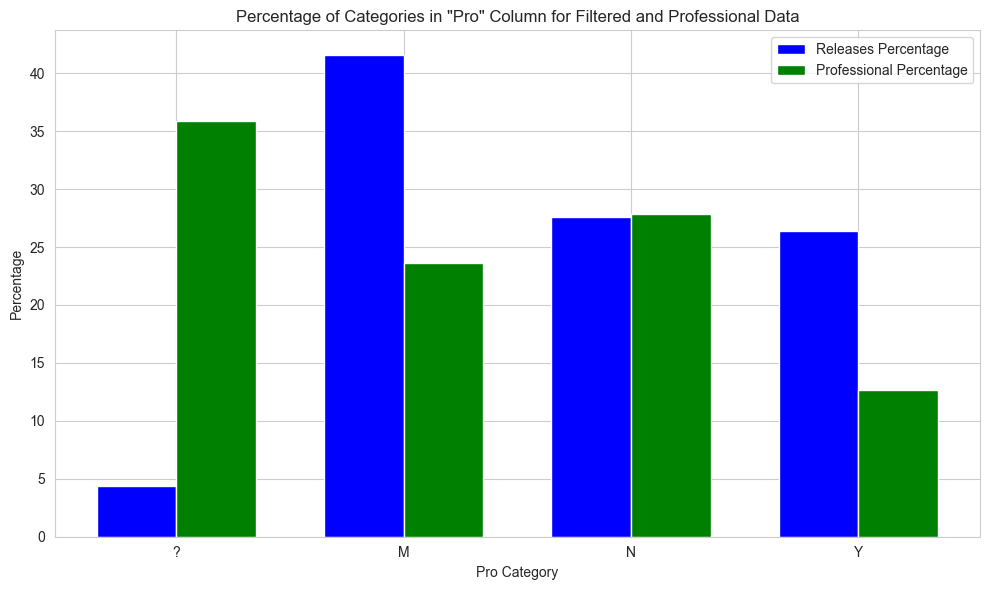

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Count the occurrences of each category in both DataFrames
filtered_pro_category_count = filtered_df['Pro'].value_counts()
professional_pro_category_count = professional['Pro'].value_counts()

# Step 2: Calculate the percentage of each category in both DataFrames
filtered_pro_category_percentage = (filtered_pro_category_count / filtered_pro_category_count.sum()) * 100
professional_pro_category_percentage = (professional_pro_category_count / professional_pro_category_count.sum()) * 100

# Step 3: Align the categories
categories = sorted(set(filtered_pro_category_percentage.index).union(set(professional_pro_category_percentage.index)))

# Step 4: Create lists of percentages for both datasets
filtered_percentages = [filtered_pro_category_percentage.get(cat, 0) for cat in categories]
professional_percentages = [professional_pro_category_percentage.get(cat, 0) for cat in categories]

# Step 5: Plot the percentages
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for filtered_df percentages
rects1 = ax.bar(x - width/2, filtered_percentages, width, label='Releases Percentage', color='blue')

# Plot bars for professional percentages
rects2 = ax.bar(x + width/2, professional_percentages, width, label='Professional Percentage', color='green')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Pro Category')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Categories in "Pro" Column for Filtered and Professional Data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()



## Decision to Remove the "Unknown" Category: ## 
We decided to remove the "unknown" category (represented as '?' or any equivalent) from the analysis because its presence was unbalanced and disproportionately affected the results. Including this category introduced bias, as it did not represent a clearly defined group of professionals. By excluding the "unknown" data, we aim to ensure that the analysis more accurately reflects the contributions and workload distribution among the clearly defined doctor categories: N (young doctors), M (advanced doctors), and Y (senior doctors).

In [67]:
# Step 1: Clean the 'Pro' column by stripping leading/trailing spaces (including non-breaking spaces)
professional['Pro'] = professional['Pro'].str.strip()
filtered_df['Pro'] = filtered_df['Pro'].str.strip()

# Step 2: Remove rows where 'Pro' is '?' in both DataFrames
professional = professional[professional['Pro'] != '?']
filtered_df = filtered_df[filtered_df['Pro'] != '?']

# Step 3: Replace all values that are not 'N' or 'Y' with 'M' in the 'Pro' column of professional
professional['Pro'] = professional['Pro'].replace(to_replace=[r'^(?![NY]).*'], value='M', regex=True)

# Display the unique values in the 'Pro' column to verify changes
print(professional['Pro'].unique())



['N' 'Y' 'M']


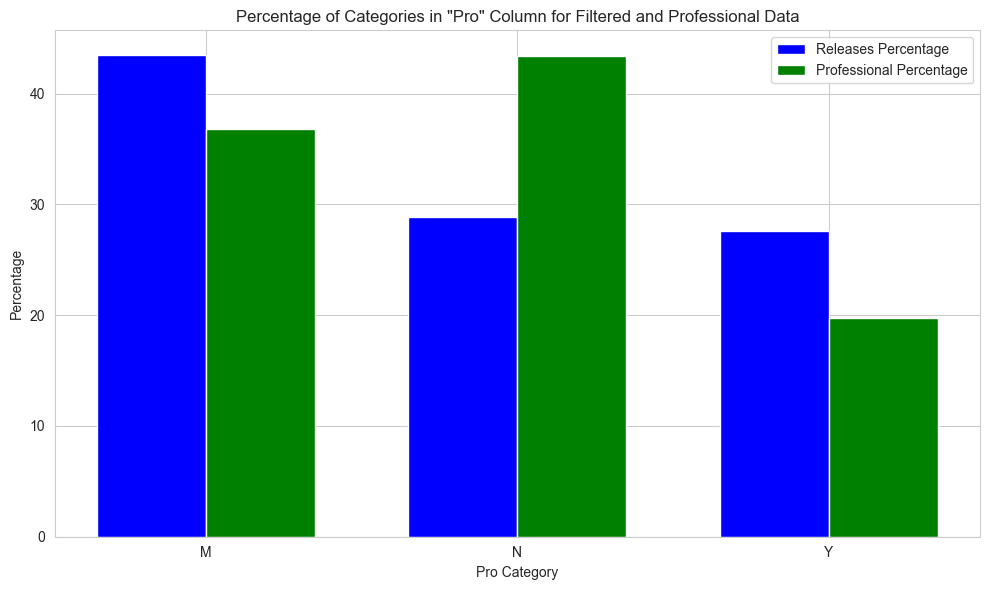

In [68]:
import numpy as np

# Step 1: Count the occurrences of each category in both DataFrames
filtered_pro_category_count = filtered_df['Pro'].value_counts()
professional_pro_category_count = professional['Pro'].value_counts()

# Step 2: Calculate the percentage of each category in both DataFrames
filtered_pro_category_percentage = (filtered_pro_category_count / filtered_pro_category_count.sum()) * 100
professional_pro_category_percentage = (professional_pro_category_count / professional_pro_category_count.sum()) * 100

# Step 3: Align the categories
categories = sorted(set(filtered_pro_category_percentage.index).union(set(professional_pro_category_percentage.index)))

# Step 4: Create lists of percentages for both datasets
filtered_percentages = [filtered_pro_category_percentage.get(cat, 0) for cat in categories]
professional_percentages = [professional_pro_category_percentage.get(cat, 0) for cat in categories]

# Step 5: Plot the percentages
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for filtered_df percentages
rects1 = ax.bar(x - width/2, filtered_percentages, width, label='Releases Percentage', color='blue')

# Plot bars for professional percentages
rects2 = ax.bar(x + width/2, professional_percentages, width, label='Professional Percentage', color='green')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Pro Category')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Categories in "Pro" Column for Filtered and Professional Data')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [69]:
# Assuming 'filtered_df' and 'professional' DataFrames are available from earlier context

# Step 1: Count the occurrences (number of doctors) for each category in 'Pro'
doctor_counts = professional['Pro'].value_counts(normalize=False)
doctor_percentage = (professional['Pro'].value_counts(normalize=True)) * 100

# Step 2: Count the occurrences of discharges (filtered_df['Pro']) as percentage
discharge_counts = filtered_df['Pro'].value_counts(normalize=False)
discharge_percentage = (filtered_df['Pro'].value_counts(normalize=True)) * 100

# Create a DataFrame with both doctor percentages and discharge percentages
summary_df = pd.DataFrame({
    'Doctor_Count': doctor_counts,
    'Doctor_Percentage': doctor_percentage,
    'Discharge_Count': discharge_counts,
    'Discharge_Percentage': discharge_percentage
})

# Fill NaN values with 0, since some categories might not exist in both DataFrames
summary_df.fillna(0, inplace=True)

# Step 3: Calculate Discharge Rate per Doctor Group
summary_df['Discharge_Rate'] = summary_df['Discharge_Percentage'] / summary_df['Doctor_Percentage']

# Step 4: Calculate Per-Doctor Discharge Rate
summary_df['Per_Doctor_Discharge_Rate'] = summary_df['Discharge_Count'] / summary_df['Doctor_Count']

# Step 5: Calculate Relative Contribution Index (RCI)
summary_df['RCI'] = summary_df['Discharge_Percentage'] / summary_df['Doctor_Percentage']

# Display the DataFrame with calculated metrics
summary_df


,Doctor_Count,Doctor_Percentage,Discharge_Count,Discharge_Percentage,Discharge_Rate,Per_Doctor_Discharge_Rate,RCI
M,56,36.842105,3086,43.526093,1.181423,55.107143,1.181423
N,66,43.421053,2048,28.885755,0.665248,31.030303,0.665248
Y,30,19.736842,1956,27.588152,1.397800,65.200000,1.397800


Young Doctors ('N') Underperform: Young doctors represent a large part of the workforce but contribute to fewer discharges. This may reflect less involvement in decision-making, possibly due to inexperience or reliance on senior doctors for complex cases.

Advanced Doctors ('M') Handle More Discharges: Advanced doctors, though fewer in number, are responsible for a disproportionately high number of discharges. This suggests they are transitioning into greater responsibilities within the department.

Senior Doctors ('Y') Play a Key Role in Complex Cases: Senior doctors, while fewer, contribute significantly to discharge decisions, likely handling more complex cases and finalizing critical discharge decisions.

In [70]:
# Step 1: Group by 'Releasing_Doctor' and calculate the average daily releases
doctor_avg_day_releases = erdoctor_df2.groupby('Releasing_Doctor')['Releases_Sum'].mean().reset_index(name='Avg_Day_Releases')

# Step 2: Get the number of unique 'Releasing_Doctor' in the original DataFrame
unique_doctors_count = len(erdoctor_df2['Releasing_Doctor'].unique()) 

# Step 3: Get the number of rows in the 'doctor_avg_day_releases' DataFrame
grouped_doctors_count = doctor_avg_day_releases['Releasing_Doctor'].nunique()

# Step 4: Print both values for comparison
print(f"Unique doctors in original DataFrame: {unique_doctors_count}")
print(f"Unique doctors in grouped DataFrame: {grouped_doctors_count}")



Unique doctors in original DataFrame: 1047
Unique doctors in grouped DataFrame: 1047


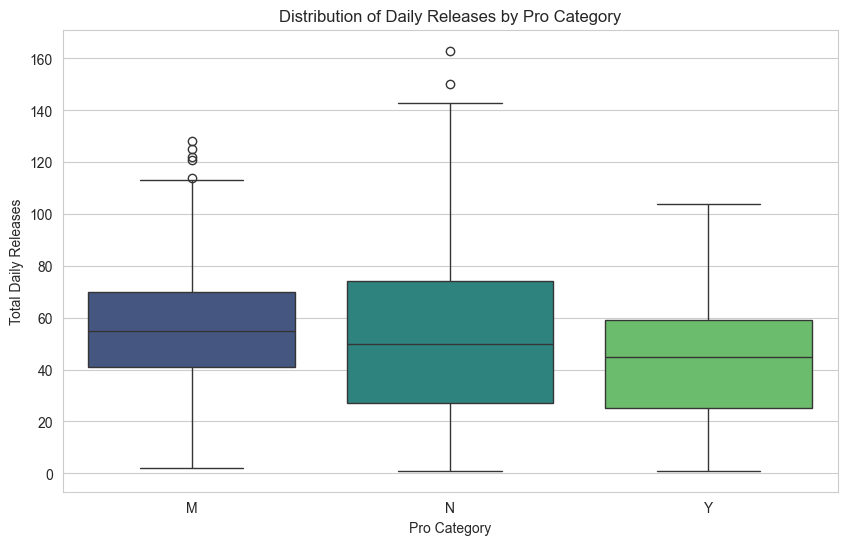

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'erdoctor_df' contains 'date', 'Releases_Sum', and 'Releasing_Doctor'
# and 'professional' contains 'Releasing_Doctor' and 'Pro'

# Step 1: Merge 'erdoctor_df' with 'professional' on 'Releasing_Doctor' to bring in the 'Pro' column
merged_df = pd.merge(erdoctor_df2, professional[['Releasing_Doctor', 'Pro']], on='Releasing_Doctor', how='left')

# Step 2: Fill NaN values in 'Releases_Sum' with 0 (if necessary)
merged_df['Releases_Sum'] = merged_df['Releases_Sum'].fillna(0)

# Step 3: Group by 'date' and 'Pro' to calculate the sum of releases for each day and Pro category
sum_releases_by_date_pro = merged_df.groupby(['date', 'Pro'])['Releases_Sum'].sum().reset_index()

# Step 4: Calculate the total sum of releases for each Pro category
total_releases_by_pro = sum_releases_by_date_pro.groupby('Pro')['Releases_Sum'].sum().reset_index()

# Step 5: Calculate the number of unique days per Pro category
unique_dates_by_pro = sum_releases_by_date_pro.groupby('Pro')['date'].nunique().reset_index()

# Step 6: Merge the total releases and unique dates to calculate the average releases per day
avg_releases_by_pro = pd.merge(total_releases_by_pro, unique_dates_by_pro, on='Pro')
avg_releases_by_pro['Avg_Daily_Releases'] = avg_releases_by_pro['Releases_Sum'] / avg_releases_by_pro['date']

# Step 1: Create a boxplot for the distribution of daily releases for each Pro category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pro', y='Releases_Sum', data=sum_releases_by_date_pro, hue='Pro', palette='viridis', legend=False)

# Step 2: Add plot details
plt.title("Distribution of Daily Releases by Pro Category")
plt.xlabel("Pro Category")
plt.ylabel("Total Daily Releases")
plt.grid(True, axis='y')

# Display the plot
plt.show()



### Explanation:

`sns.boxplot()`: This function creates the boxplot where:
- **`x='Pro'`**: Categories are placed on the x-axis (Pro categories: N, Y, M).
- **`y='Releases_Sum'`**: Total daily releases are placed on the y-axis.
- **`data=sum_releases_by_date_pro`**: Data source is the grouped DataFrame containing `Pro` and `Releases_Sum`.
- **`palette='viridis'`**: Specifies the color palette for the boxplot.

### Grid and Titles:
- The grid is enabled along the y-axis for better readability.
- Titles and labels are added to make the plot clear and descriptive.

### Result:
The boxplot will show:
- **Median** (central line in each box),
- **Interquartile range (IQR)** (the box),
- **Whiskers** (spread of the data),
- **Outliers** (points outside the whiskers).

This will give you a concise visual summary of the distribution of daily releases across the `Pro` categories (N, Y, M).


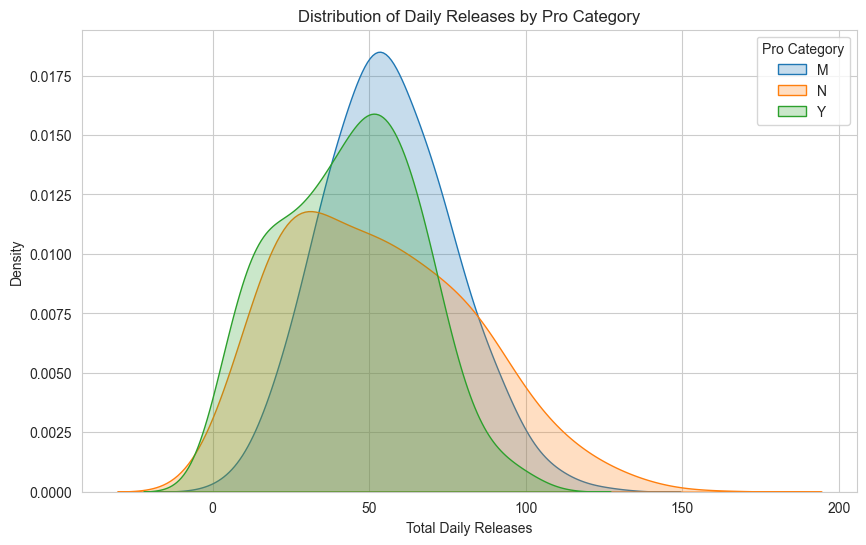

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Plot the distribution of total daily releases for each Pro category
plt.figure(figsize=(10, 6))

# Loop over each Pro category to plot its distribution
for pro_category in sum_releases_by_date_pro['Pro'].unique():
    subset = sum_releases_by_date_pro[sum_releases_by_date_pro['Pro'] == pro_category]
    sns.kdeplot(subset['Releases_Sum'], label=pro_category, fill=True, bw_adjust=1.5)

# Step 2: Add plot details
plt.title("Distribution of Daily Releases by Pro Category")
plt.xlabel("Total Daily Releases")
plt.ylabel("Density")
plt.legend(title='Pro Category')
plt.grid(True)

# Display the plot
plt.show()


### Explanation:

`sns.kdeplot()`: This function creates a **Kernel Density Estimate (KDE)** plot for visualizing the distribution of data.

- **`x='Releases_Sum'`**: The total daily releases are placed on the x-axis.
- **`hue='Pro'`**: The `Pro` categories (N, Y, M) are differentiated by different colors.


### Grid and Titles:
- The grid is enabled along the y-axis for better readability.
- Titles and labels are added to make the plot clear and descriptive.

### Result:
The **KDE plot** will show the distribution of total daily releases for each `Pro` category:
- Each `Pro` category is shown with a distinct curve.
- The plot shows how the daily releases vary for each category, highlighting the overall distribution.


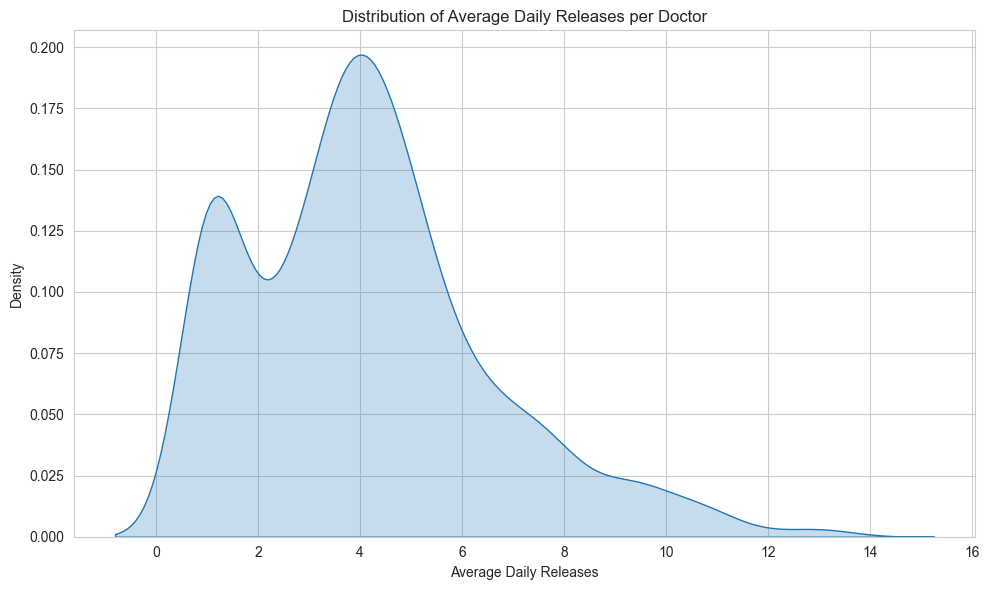

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'doctor_avg_day_releases' is the DataFrame with 'Avg_Day_Releases'

# Plotting the KDE (distribution) plot with fill instead of shade
plt.figure(figsize=(10,6))
sns.kdeplot(doctor_avg_day_releases['Avg_Day_Releases'], fill=True)

# Adding titles and labels
plt.title('Distribution of Average Daily Releases per Doctor')
plt.xlabel('Average Daily Releases')
plt.ylabel('Density')

# Show plot
plt.tight_layout()
plt.show()



In [74]:
# Step 1: Create a DataFrame with the total releases per date
# Assuming 'erdoctor_df2' contains the total releases per doctor per date
total_releases_per_date = erdoctor_df2.groupby('date')['Releases_Sum'].sum().reset_index()
total_releases_per_date.rename(columns={'Releases_Sum': 'Total_Releases'}, inplace=True)

# Step 2: Merge the total releases per date with the releases per doctor per date
df_with_rate = pd.merge(erdoctor_df2, total_releases_per_date, on='date', how='left')

# Step 3: Calculate the rate of releases per doctor
# This rate is the fraction of releases for a doctor on a given date over the total releases on that date
df_with_rate['Release_Rate'] = df_with_rate['Releases_Sum'] / df_with_rate['Total_Releases']

# Step 4: Display the first few rows to inspect the results
print(df_with_rate[['date', 'Releasing_Doctor', 'Releases_Sum', 'Total_Releases', 'Release_Rate']].head())


         date  Releasing_Doctor  Releases_Sum  Total_Releases  Release_Rate
0  01/01/2020              8706             1             240      0.004167
1  01/01/2020             11646             8             240      0.033333
2  01/01/2020              6796            11             240      0.045833
3  01/01/2020              9762             2             240      0.008333
4  01/01/2020              6774             5             240      0.020833


Statistical Summary of Total Releases per Day:
count    1461.000000
mean      275.299795
std        52.775349
min       113.000000
25%       239.000000
50%       278.000000
75%       313.000000
max       417.000000
Name: Total_Releases, dtype: float64


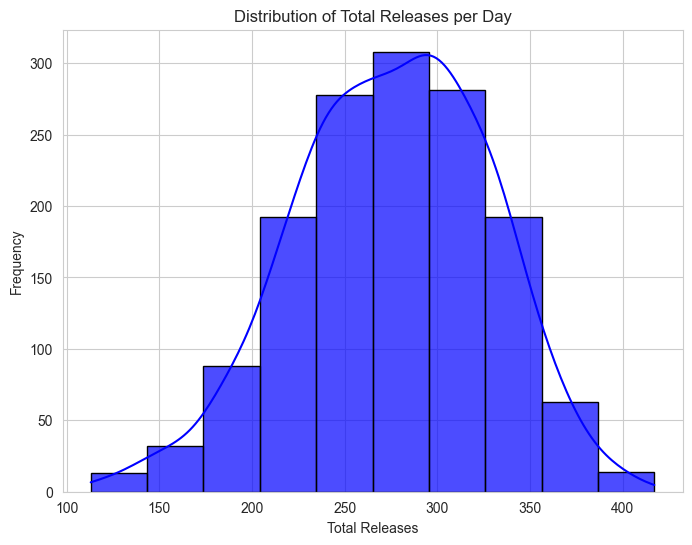

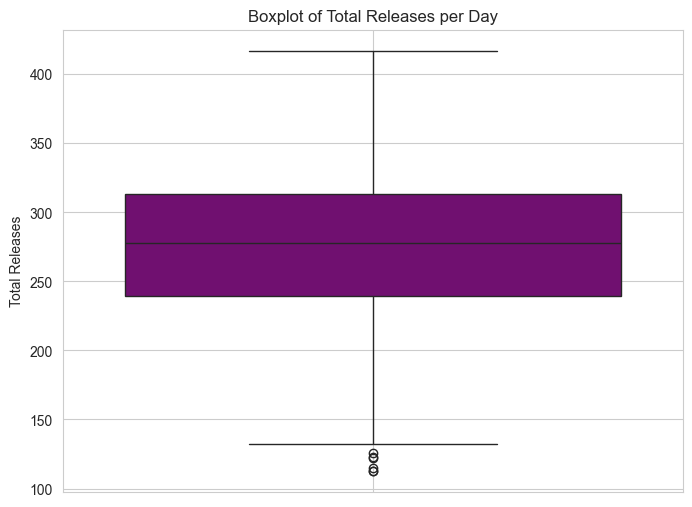

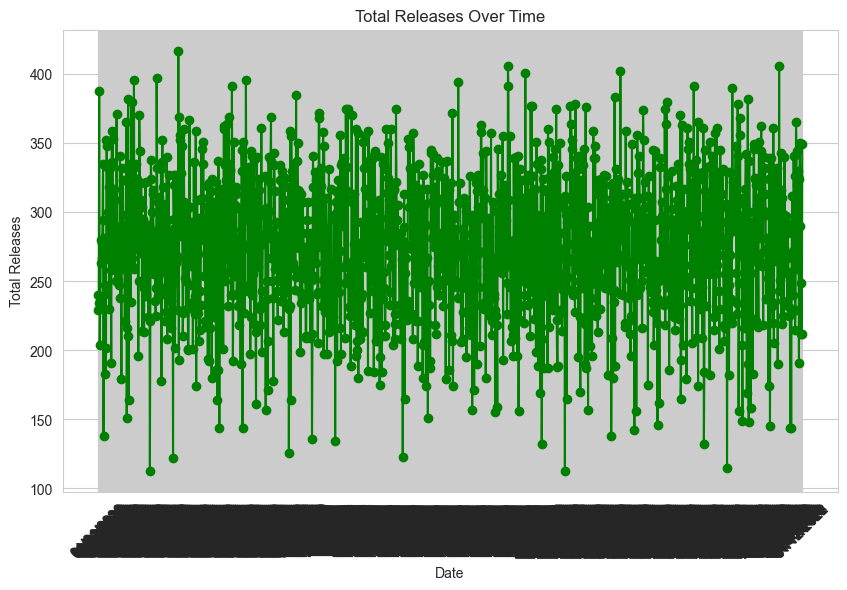

In [75]:
# Assuming erdoctor_df2 contains 'date' and 'Releases_Sum' columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by date and sum the releases for each day
sum_releases_by_date = erdoctor_df2.groupby('date')['Releases_Sum'].sum().reset_index()

# Rename the column for clarity
sum_releases_by_date.rename(columns={'Releases_Sum': 'Total_Releases'}, inplace=True)

# 1. Statistical Summary
print("Statistical Summary of Total Releases per Day:")
print(sum_releases_by_date['Total_Releases'].describe())

# 2. Distribution Plot: Histogram and KDE
plt.figure(figsize=(8, 6))
sns.histplot(sum_releases_by_date['Total_Releases'], bins=10, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Total Releases per Day")
plt.xlabel("Total Releases")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3. Boxplot: Visualizing spread and outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=sum_releases_by_date['Total_Releases'], color='purple')
plt.title("Boxplot of Total Releases per Day")
plt.ylabel("Total Releases")
plt.grid(True)
plt.show()

# 4. Time Series Plot: Total releases over time
plt.figure(figsize=(10, 6))
plt.plot(sum_releases_by_date['date'], sum_releases_by_date['Total_Releases'], marker='o', linestyle='-', color='green')
plt.title("Total Releases Over Time")
plt.xlabel("Date")
plt.ylabel("Total Releases")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Explanation of the Graphs:

This analysis visualizes the distribution and variation of **Total Releases per Day** using three different types of plots: a **distribution plot**, a **boxplot**, and a **time series plot**. Each plot provides unique insights into the data.

#### 1. Distribution Plot (Histogram with KDE):
- **Purpose**: This plot shows the **distribution of total releases** across all days. It helps us understand how the number of total releases varies day-to-day.
- **Key Insights**:
  - The distribution appears approximately **normal** (bell-shaped), indicating that most days have a total release count concentrated around the mean.
  - The **KDE (Kernel Density Estimate)** curve smooths the histogram to give a continuous representation of the underlying distribution.
  - The **peaks** around the center suggest that most days have a total release count between **250 and 300**.
  
#### 2. Boxplot:
- **Purpose**: The boxplot is used to visualize the **spread** and **outliers** in the total release data.
- **Key Insights**:
  - The **box** represents the **interquartile range (IQR)**, which contains the middle 50% of the data (between the 25th and 75th percentiles).
  - The **line inside the box** represents the **median** total releases, which is around **275**.
  - There are some **outliers** below the box (represented as individual points), indicating that on a few days, the number of total releases was significantly lower than usual.

#### 3. Time Series Plot:
- **Purpose**: This plot shows the variation in **total releases over time**, giving us a temporal view of the data.
- **Key Insights**:
  - There is a high level of variability in total releases on a day-to-day basis, but no clear upward or downward trend over time.
  - The total releases range from about **150 to 400** throughout the time period, with the majority of days clustering between **250 and 300**.
  - This plot highlights the day-to-day **fluctuations** in total releases but does not indicate any long-term patterns.


Correlation between Total Releases and Doctor Count: 0.7487135796862748


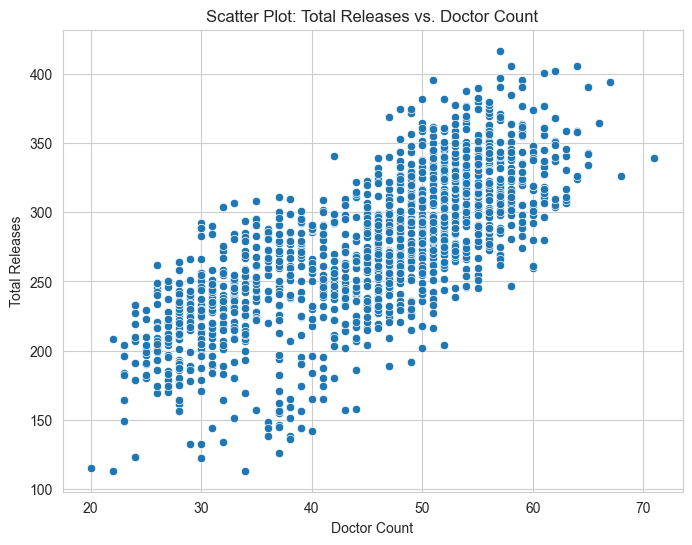

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming erdoctor_df2 contains 'date', 'Releases_Sum', and 'Releasing_Doctor' columns

# Step 1: Group by date to get sum of releases and count of unique doctors
releases_doctors_by_date = erdoctor_df2.groupby('date').agg({
    'Releases_Sum': 'sum',  # Sum of releases per day
    'Releasing_Doctor': 'nunique'  # Count of unique doctors per day
}).reset_index()

# Rename the columns for clarity
releases_doctors_by_date.rename(columns={'Releases_Sum': 'Total_Releases', 'Releasing_Doctor': 'Doctor_Count'}, inplace=True)

# Step 2: Calculate correlation between Total_Releases and Doctor_Count
correlation = releases_doctors_by_date['Total_Releases'].corr(releases_doctors_by_date['Doctor_Count'])
print(f"Correlation between Total Releases and Doctor Count: {correlation}")

# Step 3: Scatter Plot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Doctor_Count', y='Total_Releases', data=releases_doctors_by_date)
plt.title("Scatter Plot: Total Releases vs. Doctor Count")
plt.xlabel("Doctor Count")
plt.ylabel("Total Releases")
plt.grid(True)
plt.show()


Removed 6 outliers.


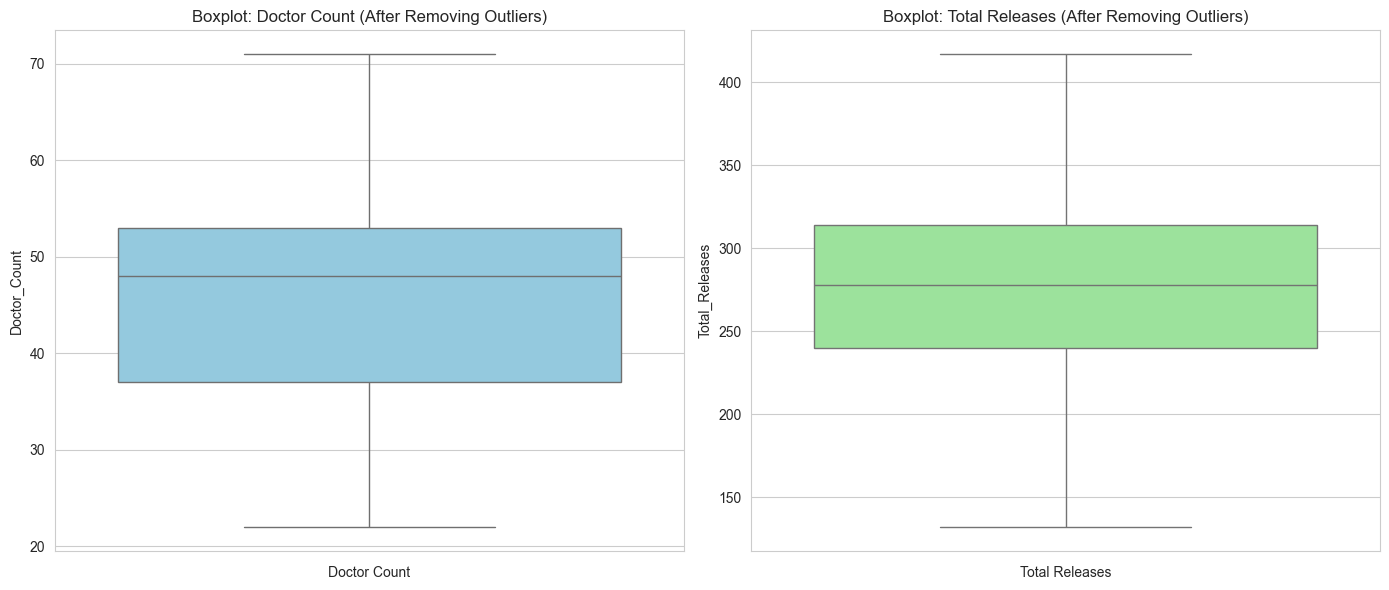

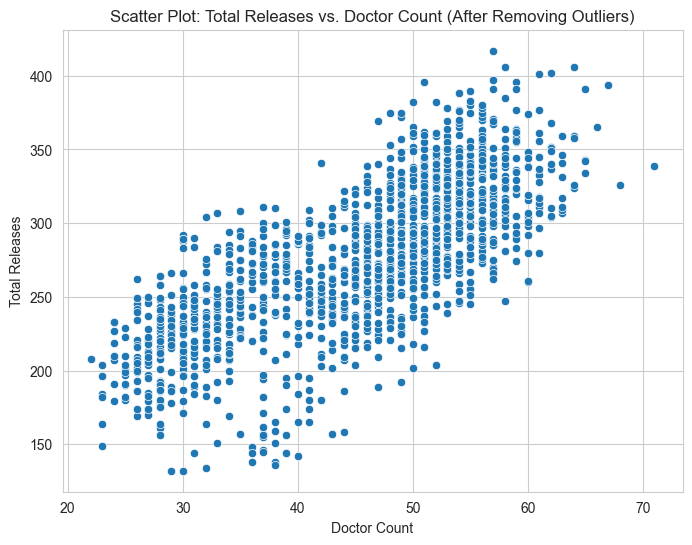

Correlation between Total Releases and Doctor Count (After Removing Outliers): 0.7465569193693736


In [77]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming erdoctor_df2 contains 'date', 'Releases_Sum', and 'Releasing_Doctor' columns

# Step 1: Group by date to get sum of releases and count of unique doctors
releases_doctors_by_date = erdoctor_df2.groupby('date').agg({
    'Releases_Sum': 'sum',  # Sum of releases per day
    'Releasing_Doctor': 'nunique'  # Count of unique doctors per day
}).reset_index()

# Rename the columns for clarity
releases_doctors_by_date.rename(columns={'Releases_Sum': 'Total_Releases', 'Releasing_Doctor': 'Doctor_Count'}, inplace=True)

# Step 2: Detect and remove outliers from both Total_Releases and Doctor_Count using the IQR method

# For Doctor_Count
Q1_doctors = releases_doctors_by_date['Doctor_Count'].quantile(0.25)
Q3_doctors = releases_doctors_by_date['Doctor_Count'].quantile(0.75)
IQR_doctors = Q3_doctors - Q1_doctors
lower_bound_doctors = Q1_doctors - 1.5 * IQR_doctors
upper_bound_doctors = Q3_doctors + 1.5 * IQR_doctors

# For Total_Releases
Q1_releases = releases_doctors_by_date['Total_Releases'].quantile(0.25)
Q3_releases = releases_doctors_by_date['Total_Releases'].quantile(0.75)
IQR_releases = Q3_releases - Q1_releases
lower_bound_releases = Q1_releases - 1.5 * IQR_releases
upper_bound_releases = Q3_releases + 1.5 * IQR_releases

# Filter the data to exclude outliers in both Doctor_Count and Total_Releases
filtered_data = releases_doctors_by_date[
    (releases_doctors_by_date['Doctor_Count'] >= lower_bound_doctors) & 
    (releases_doctors_by_date['Doctor_Count'] <= upper_bound_doctors) &
    (releases_doctors_by_date['Total_Releases'] >= lower_bound_releases) &
    (releases_doctors_by_date['Total_Releases'] <= upper_bound_releases)
]

print(f"Removed {len(releases_doctors_by_date) - len(filtered_data)} outliers.")

# Step 3: Create boxplots for Doctor_Count and Total_Releases
plt.figure(figsize=(14, 6))

# Boxplot for Doctor Count
plt.subplot(1, 2, 1)
sns.boxplot(data=filtered_data['Doctor_Count'], color='skyblue')
plt.title("Boxplot: Doctor Count (After Removing Outliers)")
plt.xlabel("Doctor Count")

# Boxplot for Total Releases
plt.subplot(1, 2, 2)
sns.boxplot(data=filtered_data['Total_Releases'], color='lightgreen')
plt.title("Boxplot: Total Releases (After Removing Outliers)")
plt.xlabel("Total Releases")

plt.tight_layout()
plt.show()

# Step 4: Scatter Plot to visualize the relationship after removing outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Doctor_Count', y='Total_Releases', data=filtered_data)
plt.title("Scatter Plot: Total Releases vs. Doctor Count (After Removing Outliers)")
plt.xlabel("Doctor Count")
plt.ylabel("Total Releases")
plt.grid(True)
plt.show()

# Step 5: Calculate correlation between Total_Releases and Doctor_Count (after removing outliers)
correlation = filtered_data['Total_Releases'].corr(filtered_data['Doctor_Count'])
print(f"Correlation between Total Releases and Doctor Count (After Removing Outliers): {correlation}")



Mean Squared Error (MSE) after removing outliers: 1227.765525172949
R-squared (R2 Score) after removing outliers: 0.5419650744769002


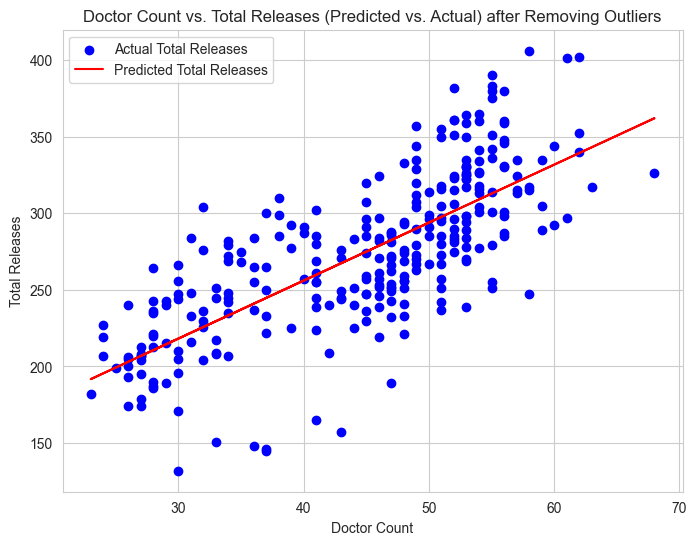

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 3: Split the filtered data into training and testing sets
X = filtered_data[['Doctor_Count']]  # Features (Doctor Count)
y = filtered_data['Total_Releases']  # Target (Total Releases)

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict the total releases on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) after removing outliers: {mse}")
print(f"R-squared (R2 Score) after removing outliers: {r2}")

# Visualize the prediction results
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color="blue", label="Actual Total Releases")
plt.plot(X_test, y_pred, color="red", label="Predicted Total Releases")
plt.title("Doctor Count vs. Total Releases (Predicted vs. Actual) after Removing Outliers")
plt.xlabel("Doctor Count")
plt.ylabel("Total Releases")
plt.legend()
plt.grid(True)
plt.show()

    

### Explanation of the Plot:

This plot shows the relationship between **Doctor Count** and **Total Releases** after removing outliers.

#### Key Components:
1. **Scatter Plot**:
   - The blue dots represent the **actual total releases** for each day, plotted against the number of doctors (Doctor Count) working that day.
   - Each dot corresponds to a specific day, where the x-axis shows the number of doctors, and the y-axis shows the total releases for that day.

2. **Regression Line**:
   - The red line is the **regression line**, which represents the model's predicted total releases based on the number of doctors.
   - The slope of the line indicates how much the total releases are expected to increase as the doctor count increases.

#### Key Observations:ס;
1. **Positive Correlation**:
   - There is a **positive correlation** between Doctor Count and Total Releases. As the number of doctors increases, the number of total releases also tends to increase.
   - However, the relationship is not perfect, as evidenced by the spread of the points around the regression line.

2. **Goodness of Fit**:
   - The **R-squared (R²) score** shown in the plot (0.54) indicates that about 54% of the variability in the total releases can be explained by the doctor count.
   - While this suggests a moderate fit, there is still a significant amount of unexplained variance, indicating that other factors may influence total releases.

3. **Model Error**:
   - The **Mean Squared Error (MSE)** value provides an estimate of the average squared difference between the actual and predicted values.
   - A lower MSE indicates better model performance, but in this case, the MSE of 1227 suggests that there are some large residuals, meaning the model's predictions are not always very close to the actual values.

---

### Conclusion:
- The model shows that there is a clear **positive relationship** between the number of doctors and total releases, indicating that as more doctors are available, the number of total releases tends to increase.
- The **R-squared (R²) score** of 0.54 suggests that the model captures about **54%** of the variability in the total releases, but **46% of the variability** remains unexplained, meaning there are likely **additional factors** that influence total releases that are not included in the model.
- The relatively high **Mean Squared Error (MSE)** value of 1227 suggests that while the model is capturing the general trend, there are **errors** in the predictions, possibly due to the limited feature set (only Doctor Count being used).
- To improve the model's performance, you could consider incorporating **additional features** (e.g., patient demographics, case complexity, time of year) that may have an impact on the total number of releases.




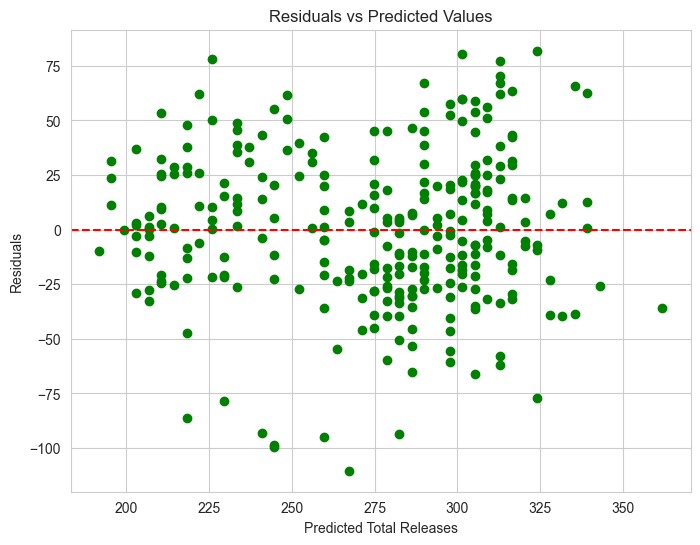

In [79]:

# 3. Residuals Plot (Residuals should ideally be randomly distributed around 0)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Total Releases")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


### Conclusions from the Plot:

#### 1. Random Distribution of Residuals:
- The residuals are randomly scattered around the red dashed line (zero residual line), indicating that there is **no clear pattern**. This suggests that the model does not have significant systematic errors and is likely **unbiased**.
- A random pattern means that the model’s errors are mostly due to **noise** and not due to a poor fit, which is a **good sign**.

#### 2. Homoscedasticity (Constant Variance of Errors):
- The spread of the residuals appears relatively **consistent across the range** of predicted values. There is no clear funnel-shaped pattern (which would indicate increasing or decreasing variance).
- This suggests that the model likely satisfies the assumption of **homoscedasticity** (constant variance of residuals), which is important for the validity of many regression models.

#### 3. No Clear Outliers:
- While there are some points with larger residuals, there doesn’t appear to be any extreme **outliers** that could significantly affect the model's fit.
- This is a **positive sign**, suggesting that the model is not being heavily influenced by a few outliers.

#### 4. Model Fit:
- Since the residuals are centered around zero and appear to be **symmetrically distributed**, we can conclude that the model is generally **fitting the data well**.
- However, there is still some spread, indicating that there is **room for improvement** in the accuracy of the model.
